# Описание проекта  
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

## Подготовка и изучение данных  

In [3]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
df_calls['duration'].sum()

1368790.0399999998

In [5]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Проверим дубликаты и пропуски в данных

In [9]:
def check(df):
    print('Кол-во дубликатов:', df.duplicated().sum())
    print('Кол-во пропущенных значений:', df.isnull().sum())
    

In [10]:
check(df_calls)


Кол-во дубликатов: 0
Кол-во пропущенных значений: id           0
call_date    0
duration     0
user_id      0
dtype: int64


In [11]:
check(df_internet)

Кол-во дубликатов: 0
Кол-во пропущенных значений: Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


In [12]:
check(df_messages)

Кол-во дубликатов: 0
Кол-во пропущенных значений: id              0
message_date    0
user_id         0
dtype: int64


In [13]:
check(df_tariffs)

Кол-во дубликатов: 0
Кол-во пропущенных значений: messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


In [14]:
check(df_users)

Кол-во дубликатов: 0
Кол-во пропущенных значений: user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64


churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Пропуски не повлияют на дайльнеший анализ, оставляем как есть.

### Для дальнейшего анализа, необходимо объеденить данные в одну таблицу
Для этого необходимо посчитать итоги по месяцам для каждого абонента

In [15]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [16]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [17]:
df_calls['user_id'].nunique()

492

In [18]:
df_internet['user_id'].nunique()

497

In [19]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],format='%Y/%m/%d %H:%M')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],format='%Y/%m/%d %H:%M')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'],format='%Y/%m/%d %H:%M')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'],format='%Y/%m/%d %H:%M')


In [20]:
df_calls['call_date'] = df_calls['call_date'].values.astype('datetime64[M]')
df_internet['session_date'] = df_internet['session_date'].values.astype('datetime64[M]')
df_messages['message_date'] = df_messages['message_date'].values.astype('datetime64[M]')
df_users['reg_date'] = df_users['reg_date'].values.astype('datetime64[M]')

#### даты приведены к единому формату

In [21]:
df_calls['call_date'].value_counts()


2018-12-01    33987
2018-11-01    29501
2018-10-01    27146
2018-09-01    24061
2018-08-01    21488
2018-07-01    18298
2018-06-01    14716
2018-05-01    12647
2018-04-01     9272
2018-03-01     6687
2018-02-01     3328
2018-01-01     1476
Name: call_date, dtype: int64

In [22]:
df_calls.rename({'call_date': 'month'}, axis=1, inplace=True)
df_internet.rename({'session_date': 'month'}, axis=1, inplace=True)
df_messages.rename({'message_date': 'month'}, axis=1, inplace=True)
df_users.rename({'reg_date': 'month'}, axis=1, inplace=True)

In [23]:
df_users['month'].value_counts()

2018-04-01    53
2018-08-01    50
2018-10-01    45
2018-07-01    44
2018-01-01    43
2018-11-01    42
2018-05-01    41
2018-06-01    40
2018-02-01    39
2018-12-01    36
2018-09-01    35
2018-03-01    32
Name: month, dtype: int64

In [24]:
df_internet['month'].value_counts()

2018-12-01    24799
2018-11-01    21817
2018-10-01    20009
2018-09-01    17512
2018-08-01    16092
2018-07-01    13548
2018-06-01    11057
2018-05-01     9408
2018-04-01     6511
2018-03-01     4885
2018-02-01     2641
2018-01-01     1117
Name: month, dtype: int64

In [25]:
df_users['month'].value_counts()

2018-04-01    53
2018-08-01    50
2018-10-01    45
2018-07-01    44
2018-01-01    43
2018-11-01    42
2018-05-01    41
2018-06-01    40
2018-02-01    39
2018-12-01    36
2018-09-01    35
2018-03-01    32
Name: month, dtype: int64

In [26]:
df_calls['duration'] = np.ceil(df_calls['duration'])

In [27]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])

In [28]:
def describe (variable, tittle, xlabel, ylabel, xlim, rangee, bins):
    print(variable.describe() )
    plt.subplot(2, 1, 1)
    plt.title(tittle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    variable.hist(bins = bins, range = (rangee), figsize=(10,10));
    plt.xlim(xlim)
    ax=plt.subplot(2, 1, 2, sharex = plt.gca())
    ax.set(xlabel=xlabel)
    ax=sns.boxplot(variable);
    ax.set(xlabel=xlabel)
        

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64


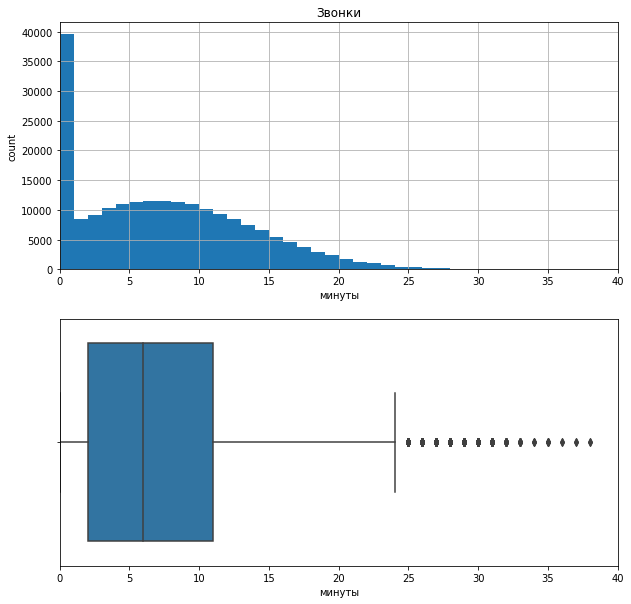

In [29]:
describe(df_calls['duration'], 'Звонки', 'минуты', 'count', (0,40), (0,100), 100)

Наблюдается очень много звонков с продолжительностью ноль минут, вероятно, это пропущенные вызовы, они повлияют на статистические показатели которые важны для корректной оценки поведения абонентов. В то же время их отсутствие не повлияет на расчеты. Учитывая, что других выжных данных эти строки не содержат их можно удалить.

In [30]:
df_calls.loc[df_calls['duration']==0, 'duration'] = None
df_calls['duration'].dropna()

2          3.0
3         14.0
4          6.0
7         19.0
8         19.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 162994, dtype: float64

count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64


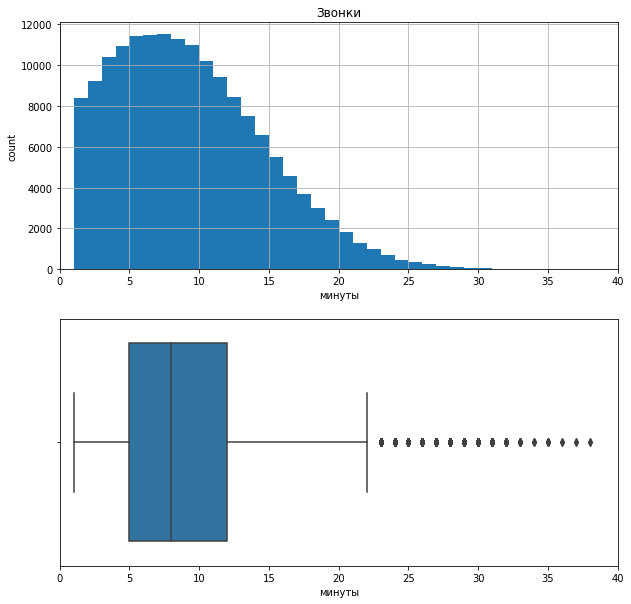

In [31]:
describe(df_calls['duration'], 'Звонки', 'минуты', 'count', (0,40), (0,100), 100)

In [32]:
df_internet.head()

,Unnamed: 0,id,mb_used,month,user_id
0,0,1000_0,113.0,2018-11-01,1000
1,1,1000_1,1053.0,2018-09-01,1000
2,2,1000_2,1198.0,2018-06-01,1000
3,3,1000_3,551.0,2018-08-01,1000
4,4,1000_4,303.0,2018-09-01,1000


count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64


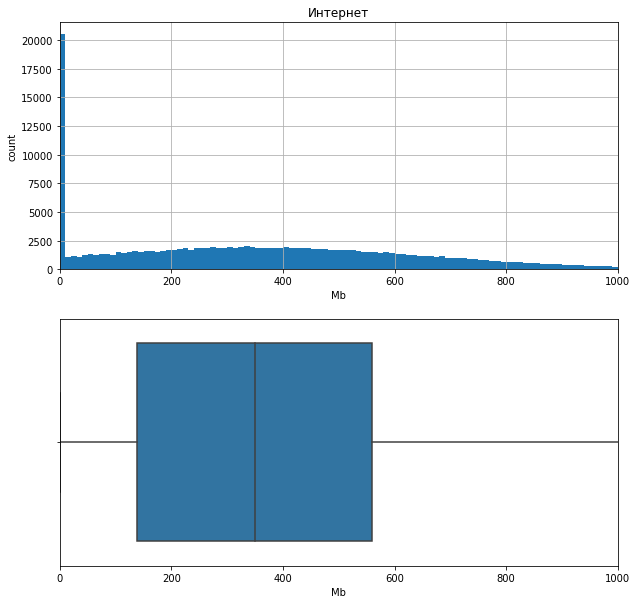

In [33]:
describe(df_internet['mb_used'], 'Интернет', 'Mb', 'count', (0,1000), (0,1000), 100)

In [34]:
df_internet.loc[df_internet['mb_used']==0, 'mb_used'] = None
df_internet['mb_used'].dropna()

0          113.0
1         1053.0
2         1198.0
3          551.0
4          303.0
           ...  
149390     753.0
149391     319.0
149392     491.0
149394    1247.0
149395     545.0
Name: mb_used, Length: 129798, dtype: float64

count    129798.000000
mean        426.581758
std         255.596114
min           1.000000
25%         228.000000
50%         401.000000
75%         593.000000
max        1725.000000
Name: mb_used, dtype: float64


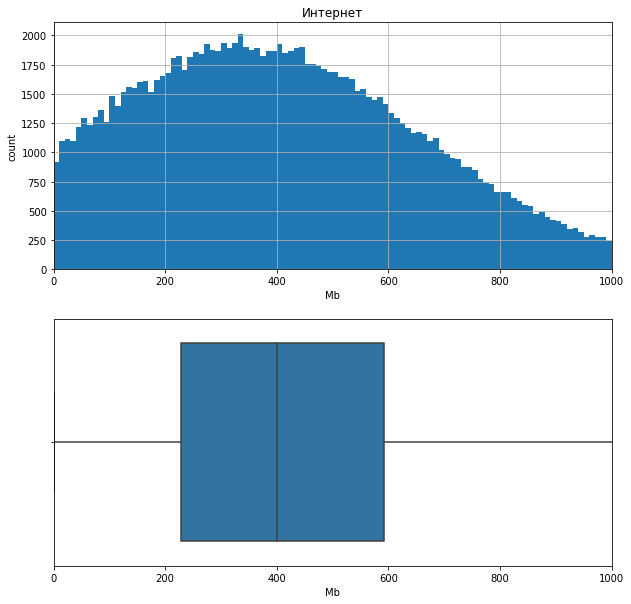

In [35]:
describe(df_internet['mb_used'], 'Интернет', 'Mb', 'count', (0,1000), (0,1000), 100)

#### Данные предобработаны, звонки и интернет сессии округлены в большую сторону, нет пропусков по месяцам, далее необходимо рассчитать итоги по месяцам.

In [36]:
df_calls = pd.DataFrame(data = df_calls) 
df_internet = pd.DataFrame(data = df_internet) 
df_messages = pd.DataFrame(data = df_messages)
df_tariffs = pd.DataFrame(data = df_tariffs)
df_users = pd.DataFrame(data = df_users)

In [37]:
df_calls.head()

,id,month,duration,user_id
0,1000_0,2018-07-01,NaN,1000
1,1000_1,2018-08-01,NaN,1000
2,1000_2,2018-06-01,3.0,1000
3,1000_3,2018-09-01,14.0,1000
4,1000_4,2018-12-01,6.0,1000


In [38]:
df_call = df_calls.groupby(['user_id', 'month'])['duration'].sum()
df_call


user_id  month     
1000     2018-05-01    159.0
         2018-06-01    172.0
         2018-07-01    340.0
         2018-08-01    408.0
         2018-09-01    466.0
                       ...  
1498     2018-10-01    247.0
1499     2018-09-01     70.0
         2018-10-01    449.0
         2018-11-01    612.0
         2018-12-01    492.0
Name: duration, Length: 3174, dtype: float64

In [39]:
df_internet.head()


,Unnamed: 0,id,mb_used,month,user_id
0,0,1000_0,113.0,2018-11-01,1000
1,1,1000_1,1053.0,2018-09-01,1000
2,2,1000_2,1198.0,2018-06-01,1000
3,3,1000_3,551.0,2018-08-01,1000
4,4,1000_4,303.0,2018-09-01,1000


In [40]:
df_interne = df_internet.groupby(['user_id', 'month'])['mb_used'].sum()
df_interne

user_id  month     
1000     2018-05-01     2256.0
         2018-06-01    23257.0
         2018-07-01    14016.0
         2018-08-01    14070.0
         2018-09-01    14581.0
                        ...   
1498     2018-10-01    20604.0
1499     2018-09-01     1848.0
         2018-10-01    17809.0
         2018-11-01    17984.0
         2018-12-01    13077.0
Name: mb_used, Length: 3203, dtype: float64

In [41]:
df_interne = pd.DataFrame(data = df_interne) 
df_call = pd.DataFrame(data = df_call) 


### Объединение данных

In [42]:
df = df_call.merge(df_interne,how='outer',on=['user_id', 'month']).reset_index()
df.head()

,user_id,month,duration,mb_used
0,1000,2018-05-01,159.0,2256.0
1,1000,2018-06-01,172.0,23257.0
2,1000,2018-07-01,340.0,14016.0
3,1000,2018-08-01,408.0,14070.0
4,1000,2018-09-01,466.0,14581.0


In [43]:
df[df['user_id']==1000]

,user_id,month,duration,mb_used
0,1000,2018-05-01,159.0,2256.0
1,1000,2018-06-01,172.0,23257.0
2,1000,2018-07-01,340.0,14016.0
3,1000,2018-08-01,408.0,14070.0
4,1000,2018-09-01,466.0,14581.0
5,1000,2018-10-01,350.0,14717.0
6,1000,2018-11-01,338.0,14768.0
7,1000,2018-12-01,333.0,9827.0


После объедениения таблиц по выбраному юзеру только 8 месяцев данных, необходимо проверить дату регистрации

In [44]:
df_users[df_users['user_id']==1000]



,user_id,age,churn_date,city,first_name,last_name,month,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra


Дата регистрации соответствует предыдущему выводу. Таблицы соеденились успешно.

In [45]:
df_messages.head()

,id,month,user_id
0,1000_0,2018-06-01,1000
1,1000_1,2018-10-01,1000
2,1000_2,2018-08-01,1000
3,1000_3,2018-06-01,1000
4,1000_4,2018-12-01,1000


In [46]:
df_message = df_messages.groupby(['user_id', 'month'])['id'].count()
df_message

user_id  month     
1000     2018-05-01    22
         2018-06-01    60
         2018-07-01    75
         2018-08-01    81
         2018-09-01    57
                       ..
1498     2018-10-01    42
1499     2018-09-01    11
         2018-10-01    48
         2018-11-01    59
         2018-12-01    66
Name: id, Length: 2717, dtype: int64

Получили кол-во сообщений отправленных каждым пользователем в определенный месяц. Необходимо присоеденить данные к основной таблице.

In [47]:
df = df.merge(df_message,how='outer',on=['user_id', 'month']).reset_index()
df.head()

,index,user_id,month,duration,mb_used,id
0,0,1000,2018-05-01,159.0,2256.0,22.0
1,1,1000,2018-06-01,172.0,23257.0,60.0
2,2,1000,2018-07-01,340.0,14016.0,75.0
3,3,1000,2018-08-01,408.0,14070.0,81.0
4,4,1000,2018-09-01,466.0,14581.0,57.0


In [48]:
df.rename({'id': 'sms'}, axis=1, inplace=True)
df.head()

,index,user_id,month,duration,mb_used,sms
0,0,1000,2018-05-01,159.0,2256.0,22.0
1,1,1000,2018-06-01,172.0,23257.0,60.0
2,2,1000,2018-07-01,340.0,14016.0,75.0
3,3,1000,2018-08-01,408.0,14070.0,81.0
4,4,1000,2018-09-01,466.0,14581.0,57.0


Готово. Теперь нужно дабваить таблицу по юзерам

In [49]:
df_users.head(5)

,user_id,age,churn_date,city,first_name,last_name,month,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-01,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-01,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-01,ultra


In [50]:
df_users[df_users['user_id']==1001]

,user_id,age,churn_date,city,first_name,last_name,month,tariff
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


На каждого юзера приходится одна строка, можно соединять таблицы без групировки.

In [51]:
df_users = pd.DataFrame(data = df_users) 

In [52]:
df = df.merge(df_users,how='left',on=['user_id']).reset_index()


In [53]:
df

,level_0,index,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff
0,0,0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1,1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
2,2,2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
3,3,3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
4,4,4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3209,3209,1489,2018-08-01,NaN,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3210,3210,3210,1489,2018-09-01,NaN,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3211,3211,3211,1489,2018-10-01,NaN,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3212,3212,3212,1489,2018-11-01,NaN,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart


In [54]:
df[df['user_id']==1000]

,level_0,index,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff
0,0,0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1,1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
2,2,2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
3,3,3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
4,4,4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
5,5,5,1000,2018-10-01,350.0,14717.0,73.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
6,6,6,1000,2018-11-01,338.0,14768.0,58.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
7,7,7,1000,2018-12-01,333.0,9827.0,70.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra


По юзеру "1000" по прежнему 8 строк по кол-ву месяцев.

In [55]:
df.head()

,level_0,index,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff
0,0,0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1,1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
2,2,2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
3,3,3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
4,4,4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra


In [56]:
df = df.drop(['level_0', 'index'], axis = 1) 
df

,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff
0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3210,1489,2018-09-01,NaN,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3211,1489,2018-10-01,NaN,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart
3212,1489,2018-11-01,NaN,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart


In [57]:
df.duplicated().sum()

0

#### Таблицы объеденены корректно

## Расчет помесячой выручки с каждого пользователя 

In [58]:
len(df[df['tariff']=='smart'])

2229

In [59]:
len(df[df['tariff']=='ultra'])

985

In [60]:

def tarif_profit(row):
    calls = row['duration']
    messages = row['sms']
    internet = row['mb_used']
    tariff = row['tariff']
    minutes_lim = df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'minutes_included'].array[0]
    message_lim = df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'messages_included'].array[0]
    internet_lim = df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'mb_per_month_included'].array[0]
 
    call_overlimit = max(calls - minutes_lim, 0)
    call_overpay = call_overlimit * df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'rub_per_minute'].array[0]
 
    messages_overlimit = max(messages - message_lim, 0)
    messages_overpay = messages_overlimit * df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'rub_per_message'].array[0]
 
 
    internet_overlimit = max(internet - internet_lim, 0)
    internet_overpay = (internet_overlimit * df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'rub_per_gb'].array[0])/1024
 
    return (call_overpay + messages_overpay + internet_overpay
            + df_tariffs.loc[df_tariffs['tariff_name'] == tariff, 'rub_monthly_fee'].array[0])
 
df['tarif_profit'] = df.apply(tarif_profit, axis=1) 

Сумма по переплате сверх тарифа за интернет посчитана с учетом перевода Mb в Gb. с наименьшими трудозатратами :) в идеале конечно заранее перевести все в Gb.

In [61]:
df

,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff,tarif_profit
0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,11066.0,17.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart,NaN
3210,1489,2018-09-01,NaN,17232.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart,NaN
3211,1489,2018-10-01,NaN,19588.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart,NaN
3212,1489,2018-11-01,NaN,17516.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-01,smart,NaN


## Анализ данных

###  Сравнение пользователей по тарифам. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [62]:
df.head()

,user_id,month_x,duration,mb_used,sms,age,churn_date,city,first_name,last_name,month_y,tariff,tarif_profit
0,1000,2018-05-01,159.0,2256.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
1,1000,2018-06-01,172.0,23257.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
2,1000,2018-07-01,340.0,14016.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
3,1000,2018-08-01,408.0,14070.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0
4,1000,2018-09-01,466.0,14581.0,57.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-01,ultra,1950.0


Тафиф: ultra переменная: duration
Среднее: 545.4511041009464
Дисперсия: 94203.41839614812
Стандартное отклонение: 306.92575388218586

Тафиф: smart переменная: duration
Среднее: 419.0629779577148
Дисперсия: 35844.1895513438
Стандартное отклонение: 189.3256177894154



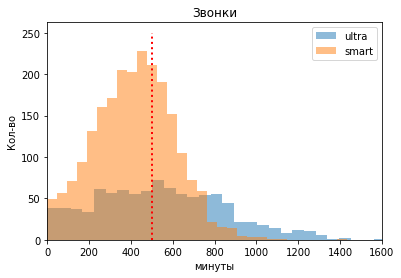

In [63]:
def stat_info2(indicator, title, xlabel, bins, xlim) :
    for tariff in ['ultra', 'smart']:
        df.loc[df['tariff'] == tariff, indicator].mean()
        var = np.var(df.loc[df['tariff'] == tariff, indicator], ddof=1)
        standard_deviation = np.sqrt(var)
        print("Тафиф:", tariff, "переменная:", indicator)
        print("Среднее:", df.loc[df['tariff'] == tariff, indicator].mean())
        print("Дисперсия:", var)
        print("Стандартное отклонение:", standard_deviation)
        print()
      
    
    for tariff in ['ultra', 'smart']:
        df.query('tariff == @tariff')[indicator].plot(kind='hist', bins=bins, alpha = 0.5)
        plt.legend(['ultra', 'smart'])
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Кол-во")
        plt.xlim(xlim)
        

   
    
 
plt.vlines(500, 0, 250,
          color = 'r', 
          label='лимит smart',
          linewidth = 2,    
          linestyle = ':'
          )   


stat_info2('duration', "Звонки", "минуты", 30, {0, 1600})

У Smart распределение Стьюдента, у ultra распределение имеет скошенность в отрицательну сторону

Тафиф: ultra переменная: sms
Среднее: 61.161006289308176
Дисперсия: 2109.6591828651995
Стандартное отклонение: 45.93102636416042

Тафиф: smart переменная: sms
Среднее: 38.71644120707596
Дисперсия: 717.5942011753547
Стандартное отклонение: 26.787948804926344



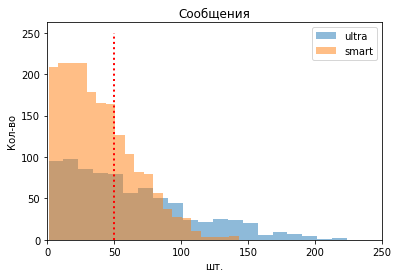

In [64]:
plt.vlines(50, 0, 250,
          color = 'r', 
          label='лимит smart',
          linewidth = 2,    
          linestyle = ':'
          )   

stat_info2('sms', "Сообщения", "шт.", 20, {0, 250})

Распределение у обоих тарифов имеет скошенность в отрицательну сторону

Тафиф: ultra переменная: mb_used
Среднее: 19686.76717948718
Дисперсия: 99043439.60795662
Стандартное отклонение: 9952.057054094726

Тафиф: smart переменная: mb_used
Среднее: 16236.47262118492
Дисперсия: 34443100.68133359
Стандартное отклонение: 5868.824471845583



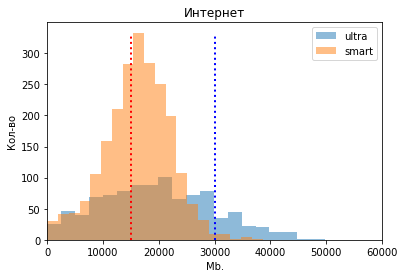

In [65]:
plt.vlines(15000, 0, 330,
          color = 'r', 
          label='лимит smart',
          linewidth = 2,    
          linestyle = ':'
          ) 
plt.vlines(30000, 0, 330,
          color = 'b', 
          label='лимит ultra',
          linewidth = 2,    
          linestyle = ':'
          ) 
stat_info2('mb_used', "Интернет", "Mb.", 20, {0, 60000})

У Smart распределение Пуассона, у ultra распределение имеет скошенность в отрицательну сторону

Все три показателя имеют примерно одих характер распределения. У пользователей smart среднее примерно совпадает с лимитом услуг включенных в тариф. Характер распределений говорит о привязке к лимиту, когда у пользователей ultra напротив, лимит очень высокий, поэтому такой привязки нет, абоненты не задумываются о лимитах и их среднее значитильно выше чем у smart. 

Тафиф: ultra переменная: tarif_profit
Среднее: 2040.7979112990358
Дисперсия: 99409.83110903448
Стандартное отклонение: 315.29324621538353

Тафиф: smart переменная: tarif_profit
Среднее: 1234.3196964751958
Дисперсия: 627648.6635840115
Стандартное отклонение: 792.2428059528288



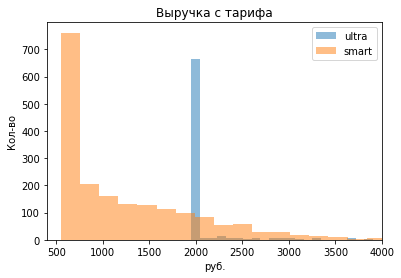

In [66]:
stat_info2('tarif_profit', "Выручка с тарифа", "руб.", 30, {400, 4000})

stat_info2('mb_used', "Интернет", "Мб.", 20, {0, 50000})

## Проверка гипотез
Неоходимо сформировать нулевую гипотезу. H₀ всегда формулируется так, чтобы использовать знак равенства.

### Проверим гипотезы: 
Нулеая гипотеза: "средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается"  
Альтернативная: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"  
аргумент "equal_var" установлен "False" т.к. дисперсии не воборок не равны

In [67]:
ultra = df.loc[df['tariff'] == 'ultra', 'tarif_profit']
smart = df.loc[df['tariff'] == 'smart', 'tarif_profit']

alpha = 0.05  

results = st.ttest_ind(ultra, smart, nan_policy='omit', equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.235968878802973e-248
Отвергаем нулевую гипотезу


#### Нулевая гипотеза отвергнута, соответственно подтверждается гипотеза альтернативная "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

### Проверим следующие  гипотезы:
Нулевая гипотеза: "средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионовя"  
Альтернаятивная : "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионовя"  
аргумент "equal_var" установлен "False" т.к. дисперсии не воборок не равны

In [68]:

moscow = df.loc[df['city'] == 'Москва', 'tarif_profit']
not_moscow = df.loc[df['city'] != 'Москва', 'tarif_profit']

alpha = 0.05  

results = st.ttest_ind(moscow, not_moscow,nan_policy='omit', equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.07219920584210616
Не получилось отвергнуть нулевую гипотезу


#### Нулевая гипотеза отвергнута, соответственно подтверждается гипотеза альтернативная "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионовя"

# Вывод  


В выборке, клиенов ultra более чем в два раза меньше чем клиентов smart, необходимо проверить корректность выгрузки выборки, выводы сделаны исходя из имеющихся данных

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:
Больший доход приносит тариф ultra за счет высокой абонентской платы, в среднем абонент платит за него 2040руб/мес., пользователи выбирают его из-за высоких лимитов по услугам, и редко расходуют весь предоставленный лимит, поэтому они не платят сверх тарифа за редким исключением.

В тарифе Smart пользователи стараются экономить за счет предоставленых лимитов и меньше пользуются услугами, за то гораздо чаще выходят за пределы лимитов, в среднем пользователь на этом тарифе платит 1234руб.

По характеру распределений в потребляемых услугах можно сделать вывод, что тарифом пользуются разные категории абонентов.

Вывод - тарифы предназначены для разных категорий пользователей, следует продвигать оба тарифа, но для разных пользователей.